# Testing

/opt/anaconda3/envs/Python3v6/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide


True

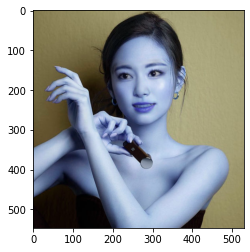

In [4]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import os

PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
bg_path = "./input_im/female/jennie1.jpeg" #背景照片(./bg_im/ .jpeg)
female_path = "./input_im/female/zu1.jpg" #新娘照片
male_path = "./input_im/female/jisoo1.jpeg" #新郎照片(./input_im/male/zy2.jpeg)

#讀入相片
bg_or = cv2.imread(bg_path) #背景照片
f_im_or = cv2.imread(female_path) #新娘照片
m_im_or = cv2.imread(male_path) #新郎照片

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

##分割照片
def cut(im):
    faces = detector(im, 1)
    
    for face in faces:
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()
        img_cap = im[y1-70:y2+70, x1-70:x2+70]
        
    return img_cap

bg = cut(bg_or)
f_im = cv2.resize(cut(f_im_or), bg.shape[:2])
m_im = cv2.resize(cut(m_im_or), bg.shape[:2]) #新郎照片

#提取面部標誌
def get_landmarks(im):
    rects = detector(im, 1)
    
    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces

    return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

def transformation_from_points(points1, points2):  #points1=bg, points2=input
    points1 = points1.astype(np.float64) #將輸入矩陣轉換為浮點型
    points2 = points2.astype(np.float64)
    
    c1 = np.mean(points1, axis=0) 
    c2 = np.mean(points2, axis=0)
    points1 -= c1  #將每一個點集減去它的矩心
    points2 -= c2
    
    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1  #將每一個點集除以它的標準偏差。這消除了縮放偏差
    points2 /= s2
    
    #奇異值分解（singular value decomposition）計算旋轉部分
    U, S, Vt = np.linalg.svd(points1.T * points2)
    R = (U * Vt).T
    
    #將整個變換過程以仿射變換矩陣形式返回
    return np.vstack([np.hstack(((s2 / s1) * R,
                                      c2.T - (s2 / s1) * R * c1.T)),
                        np.matrix([0., 0., 1.])]), R

#將第二個圖片對映到第一個圖片上
def warp_im(im, M, dshape):
    output_im = np.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                  M[:2],
                  (dshape[1], dshape[0]),
                  dst=output_im,
                  borderMode=cv2.BORDER_TRANSPARENT,
                  flags=cv2.WARP_INVERSE_MAP)
    return output_im

#修正膚色和光線，改變圖2 的顏色來匹配圖1，也就是用 im 除以 im 的高斯模糊，然後乘以 bg 的高斯模糊
COLOUR_CORRECT_BLUR_FRAC = 0.6
LEFT_EYE_POINTS = list(range(42, 48))
RIGHT_EYE_POINTS = list(range(36, 42))

def correct_colours(bg, im, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * np.linalg.norm(
                             np.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                             np.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    bg_blur = cv2.GaussianBlur(bg, (blur_amount, blur_amount), 0)
    im_blur = cv2.GaussianBlur(im, (blur_amount, blur_amount), 0)
    
    # Avoid divide-by-zero errors.
    #im_blur += 128 * (im_blur <= 1.0)
    
    return (im.astype(np.float64) * bg_blur.astype(np.float64) / im_blur.astype(np.float64))

#將圖2 的特徵融合到圖1 中
LEFT_EYE_POINTS = list(range(42, 48))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_BROW_POINTS = list(range(17, 22))
NOSE_POINTS = list(range(27, 35))
MOUTH_POINTS = list(range(48, 61))
OVERLAY_POINTS = [
   LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
   NOSE_POINTS + MOUTH_POINTS,
]
FEATHER_AMOUNT = 11

def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)
    
def get_face_mask(im, landmarks):
    im = np.zeros(im.shape[:2], dtype=np.float64)
    
    for group in OVERLAY_POINTS:
        draw_convex_hull(im,
                        landmarks[group],
                        color=1)
    im = np.array([im, im, im]).transpose((1, 2, 0))
    
    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)
   
    return im


bg_points = bg_landmarks = get_landmarks(bg)
f_points = f_landmarks = get_landmarks(f_im)
m_points = m_landmarks = get_landmarks(m_im)



M,R = transformation_from_points(bg_points, f_points)
mask = get_face_mask(f_im, f_landmarks)
warped_mask = warp_im(mask, M, bg.shape)
combined_mask = np.max([get_face_mask(bg, bg_landmarks), warped_mask], axis=0)
warped_im = warp_im(f_im,M,bg.shape)
warped_corrected_im = correct_colours(bg, warped_im, bg_landmarks)

#output_im = bg * (1.0 - combined_mask) + warped_corrected_im * combined_mask
cv2.imwrite('mask.jpeg',warped_corrected_im * combined_mask)
a = cv2.imread('mask.jpeg')
res_face = bg * (1.0 - combined_mask) + a

import os
os.remove('mask.jpeg')


def fix(im):
    faces = detector(im, 1)
    
    for face in faces:
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()
        im[y1-70:y2+70, x1-70:x2+70] = res_face
        
    return im

result = fix(bg_or)
plt.imshow(result)
plt.show

cv2.imwrite('result_im/jennie1_zu1.jpeg',result)

# Testing man at right isde

/opt/anaconda3/envs/Python3v6/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide


True

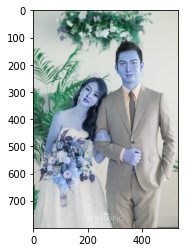

In [93]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import os

PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
bg_path = "./bg_im/man_R/wed4.jpeg" #背景照片(./bg_im/ .jpeg)
female_path = "./input_im/female/jennie1.jpeg" #新娘照片
male_path = "./input_im/male/kor3.jpeg" #新郎照片(./input_im/male/zy2.jpeg)

#讀入相片
bg_or = cv2.imread(bg_path) #背景照片
f_im_or = cv2.imread(female_path) #新娘照片
m_im_or = cv2.imread(male_path) #新郎照片

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)


def cut(im):
    cut = []
    left = []
    faces = detector(im, 1)
    for face in faces:
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()
        img_cap = im[y1-50:y2+50, x1-50:x2+50]
        cut.append(img_cap)
        left.append(x1)
    return cut , left , img_cap

    
[bg_f_im, bg_m_im], bg_left,_ = cut(bg_or)
#bg_list, bg_left,_ = cut(bg_or)
#bg_f_im, bg_m_im = bg_list
size = max(bg_f_im.shape ,bg_m_im.shape)
f_im = cv2.resize(cut(f_im_or)[2], (size[1], size[0]))
m_im = cv2.resize(cut(m_im_or)[2], (size[1], size[0]))


#提取面部標誌
def get_landmarks(im):
    rects = detector(im, 1)
    
    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces

    return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

def transformation_from_points(points1, points2):  #points1=bg, points2=input
    points1 = points1.astype(np.float64) #將輸入矩陣轉換為浮點型
    points2 = points2.astype(np.float64)
    
    c1 = np.mean(points1, axis=0) 
    c2 = np.mean(points2, axis=0)
    points1 -= c1  #將每一個點集減去它的矩心
    points2 -= c2
    
    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1  #將每一個點集除以它的標準偏差。這消除了縮放偏差
    points2 /= s2
    
    #奇異值分解（singular value decomposition）計算旋轉部分
    U, S, Vt = np.linalg.svd(points1.T * points2)
    R = (U * Vt).T
    
    #將整個變換過程以仿射變換矩陣形式返回
    return np.vstack([np.hstack(((s2 / s1) * R,
                                      c2.T - (s2 / s1) * R * c1.T)),
                        np.matrix([0., 0., 1.])]), R

#將第二個圖片對映到第一個圖片上
def warp_im(im, M, dshape):
    output_im = np.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                  M[:2],
                  (dshape[1], dshape[0]),
                  dst=output_im,
                  borderMode=cv2.BORDER_TRANSPARENT,
                  flags=cv2.WARP_INVERSE_MAP)
    return output_im

#修正膚色和光線，改變圖2 的顏色來匹配圖1，也就是用 im 除以 im 的高斯模糊，然後乘以 bg 的高斯模糊
COLOUR_CORRECT_BLUR_FRAC = 1 #0.6
LEFT_EYE_POINTS = list(range(42, 48))
RIGHT_EYE_POINTS = list(range(36, 42))

def correct_colours(bg, im, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * np.linalg.norm(
                             np.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                             np.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    bg_blur = cv2.GaussianBlur(bg, (blur_amount, blur_amount), 0)
    im_blur = cv2.GaussianBlur(im, (blur_amount, blur_amount), 0)
    
    # Avoid divide-by-zero errors.
    #im_blur += 128 * (im_blur <= 1.0)
    
    return (im.astype(np.float64) * bg_blur.astype(np.float64) / im_blur.astype(np.float64))

#將圖2 的特徵融合到圖1 中
LEFT_EYE_POINTS = list(range(42, 48))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_BROW_POINTS = list(range(17, 22))
NOSE_POINTS = list(range(27, 35))
MOUTH_POINTS = list(range(48, 61))
OVERLAY_POINTS = [
   LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
   NOSE_POINTS + MOUTH_POINTS,
]
FEATHER_AMOUNT = 11

def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)
    
def get_face_mask(im, landmarks):
    im = np.zeros(im.shape[:2], dtype=np.float64)
    
    for group in OVERLAY_POINTS:
        draw_convex_hull(im,
                        landmarks[group],
                        color=1)
    im = np.array([im, im, im]).transpose((1, 2, 0))
    
    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)
   
    return im


def combine(bg_im, input_im, gender):
    bg_points = bg_landmarks = get_landmarks(bg_im)
    input_points = input_landmarks = get_landmarks(input_im)
    
    M,R = transformation_from_points(bg_points, input_points)
    mask = get_face_mask(input_im, input_landmarks)
    warped_mask = warp_im(mask, M, bg_im.shape) #bg_im.shape
    combined_mask = np.max([get_face_mask(bg_im, bg_landmarks), warped_mask], axis=0)
    warped_im = warp_im(input_im,M, bg_im.shape) #bg_im.shape
    warped_corrected_im = correct_colours(bg_im, warped_im, bg_landmarks)
    
    #res_face = bg_im * (1.0 - combined_mask) + warped_corrected_im * combined_mask
    cv2.imwrite(f"mask_{gender}.jpeg",warped_corrected_im * combined_mask)
    a = cv2.imread(f"mask_{gender}.jpeg")
    res_face = bg_im * (1.0 - combined_mask) + a
    
    return res_face

res_face = []
res_face.append(combine(bg_f_im, f_im,'f'))
res_face.append(combine(bg_m_im, m_im,'m')) #(bg_m_im, m_im)

def fix(im,res_face):
    faces = detector(im, 1)
    
    for i in range(len(faces)):
        x1 = faces[i].left()
        y1 = faces[i].top()
        x2 = faces[i].right()
        y2 = faces[i].bottom()
        im[y1-50:y2+50, x1-50:x2+50] = res_face[i]
        
    return im

result = fix(bg_or,res_face)
plt.imshow(result)
plt.show

cv2.imwrite('result_im/mix6_1.0.jpeg',result)

#import os
#os.remove('mask.jpeg')

/opt/anaconda3/envs/Python3v6/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide


True

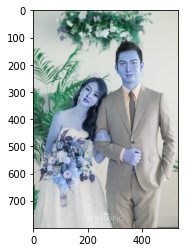

In [93]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import os

PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
bg_path = "./bg_im/man_R"
female_path = "./input_im/female/jennie1.jpeg" #新娘照片
male_path = "./input_im/male/kor3.jpeg" #新郎照片(./input_im/male/zy2.jpeg)

#讀入相片
bg_or = cv2.imread(bg_path) #背景照片
f_im_or = cv2.imread(female_path) #新娘照片
m_im_or = cv2.imread(male_path) #新郎照片

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)


def cut(im):
    cut = []
    left = []
    faces = detector(im, 1)
    for face in faces:
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()
        img_cap = im[y1-50:y2+50, x1-50:x2+50]
        cut.append(img_cap)
        left.append(x1)
    return cut , left , img_cap

    
[bg_f_im, bg_m_im], bg_left,_ = cut(bg_or)
size = max(bg_f_im.shape ,bg_m_im.shape)
f_im = cv2.resize(cut(f_im_or)[2], (size[1], size[0]))
m_im = cv2.resize(cut(m_im_or)[2], (size[1], size[0]))


#提取面部標誌
def get_landmarks(im):
    rects = detector(im, 1)
    
    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces

    return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

def transformation_from_points(points1, points2):  #points1=bg, points2=input
    points1 = points1.astype(np.float64) #將輸入矩陣轉換為浮點型
    points2 = points2.astype(np.float64)
    
    c1 = np.mean(points1, axis=0) 
    c2 = np.mean(points2, axis=0)
    points1 -= c1  #將每一個點集減去它的矩心
    points2 -= c2
    
    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1  #將每一個點集除以它的標準偏差。這消除了縮放偏差
    points2 /= s2
    
    #奇異值分解（singular value decomposition）計算旋轉部分
    U, S, Vt = np.linalg.svd(points1.T * points2)
    R = (U * Vt).T
    
    #將整個變換過程以仿射變換矩陣形式返回
    return np.vstack([np.hstack(((s2 / s1) * R,
                                      c2.T - (s2 / s1) * R * c1.T)),
                        np.matrix([0., 0., 1.])]), R

#將第二個圖片對映到第一個圖片上
def warp_im(im, M, dshape):
    output_im = np.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                  M[:2],
                  (dshape[1], dshape[0]),
                  dst=output_im,
                  borderMode=cv2.BORDER_TRANSPARENT,
                  flags=cv2.WARP_INVERSE_MAP)
    return output_im

#修正膚色和光線，改變圖2 的顏色來匹配圖1，也就是用 im 除以 im 的高斯模糊，然後乘以 bg 的高斯模糊
COLOUR_CORRECT_BLUR_FRAC = 1 #0.6
LEFT_EYE_POINTS = list(range(42, 48))
RIGHT_EYE_POINTS = list(range(36, 42))

def correct_colours(bg, im, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * np.linalg.norm(
                             np.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                             np.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    bg_blur = cv2.GaussianBlur(bg, (blur_amount, blur_amount), 0)
    im_blur = cv2.GaussianBlur(im, (blur_amount, blur_amount), 0)
    
    return (im.astype(np.float64) * bg_blur.astype(np.float64) / im_blur.astype(np.float64))


#將圖2 的特徵融合到圖1 中
LEFT_EYE_POINTS = list(range(42, 48))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_BROW_POINTS = list(range(17, 22))
NOSE_POINTS = list(range(27, 35))
MOUTH_POINTS = list(range(48, 61))
OVERLAY_POINTS = [
   LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
   NOSE_POINTS + MOUTH_POINTS,
]
FEATHER_AMOUNT = 11

def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)
    
def get_face_mask(im, landmarks):
    im = np.zeros(im.shape[:2], dtype=np.float64)
    
    for group in OVERLAY_POINTS:
        draw_convex_hull(im,
                        landmarks[group],
                        color=1)
    im = np.array([im, im, im]).transpose((1, 2, 0))
    
    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)
   
    return im


def combine(bg_im, input_im, gender):
    bg_points = bg_landmarks = get_landmarks(bg_im)
    input_points = input_landmarks = get_landmarks(input_im)
    
    M,R = transformation_from_points(bg_points, input_points)
    mask = get_face_mask(input_im, input_landmarks)
    warped_mask = warp_im(mask, M, bg_im.shape) #bg_im.shape
    combined_mask = np.max([get_face_mask(bg_im, bg_landmarks), warped_mask], axis=0)
    warped_im = warp_im(input_im,M, bg_im.shape) #bg_im.shape
    warped_corrected_im = correct_colours(bg_im, warped_im, bg_landmarks)
    
    #res_face = bg_im * (1.0 - combined_mask) + warped_corrected_im * combined_mask
    cv2.imwrite(f"mask_{gender}.jpeg",warped_corrected_im * combined_mask)
    a = cv2.imread(f"mask_{gender}.jpeg")
    res_face = bg_im * (1.0 - combined_mask) + a
    
    return res_face

res_face = []
res_face.append(combine(bg_f_im, f_im,'f'))
res_face.append(combine(bg_m_im, m_im,'m')) #(bg_m_im, m_im)

def fix(im,res_face):
    faces = detector(im, 1)
    
    for i in range(len(faces)):
        x1 = faces[i].left()
        y1 = faces[i].top()
        x2 = faces[i].right()
        y2 = faces[i].bottom()
        im[y1-50:y2+50, x1-50:x2+50] = res_face[i]
        
    return im

result = fix(bg_or,res_face)
plt.imshow(result)
plt.show

cv2.imwrite('result_im/mix6_1.0.jpeg',result)

#import os
#os.remove('mask.jpeg')

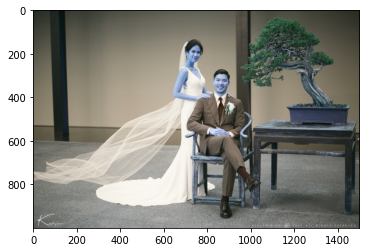

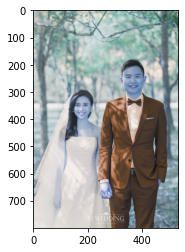

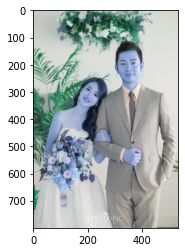

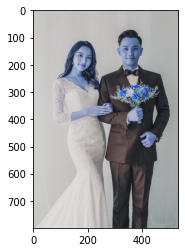

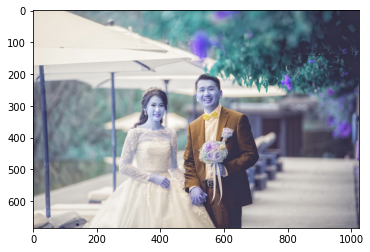

In [103]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import os

PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
bg_path = "./bg_im/man_R" #背景照片(./bg_im/ .jpeg)
female_path = "./input_im/female/jennie1.jpeg" #新娘照片
male_path = "./input_im/male/kor3.jpeg" #新郎照片(./input_im/male/zy2.jpeg)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)


f_im_or = cv2.imread(female_path) #新娘照片
m_im_or = cv2.imread(male_path) #新郎照片

bg_or_list = []
for filename in os.listdir(bg_path):
    bg_or_list.append(cv2.imread(bg_path+"/"+filename))
    
for bg_or in bg_or_list:
    plt.imshow(bg_or)
    plt.show()